In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from njit_funcs_recursive_grid import *
from backtest import backtest
from plotting import plot_fills
from downloader import Downloader
from pure_funcs import (
    denumpyize,
    numpyize,
    candidate_to_live_config,
    calc_spans,
    analyze_fills,
    create_xk,
    round_dynamic,
    round_values,
    sort_dict_keys,
)
from procedures import (
    dump_live_config,
    load_live_config,
    add_argparse_args,
    prepare_backtest_config,
    make_get_filepath,
)
from time import time
import sys
import argparse
import pprint
import matplotlib.pyplot as plt
import json
import pandas as pd
import numpy as np

using numba
using numba


In [3]:
plt.rcParams["figure.figsize"] = [16, 9]
plt.rcParams["figure.facecolor"] = "w"
pd.set_option("display.precision", 10)

In [4]:
class Args:
    def __init__(self):
        self.backtest_config_path = "configs/backtest/default.hjson"
        self.exchange = "binance"
        self.symbol = "XMRUSDT"
        self.market_type = "futures"
        self.user = "binance_01"
        self.start_date = "2021-05-01"
        self.end_date = "2022-01-21"
        self.starting_balance = 10000.0
        self.starting_configs = ""
        self.base_dir = "backtests"


config = await prepare_backtest_config(Args())
dl = Downloader(config)
sts = time()
data = await dl.get_sampled_ticks()
timestamps = data[:, 0]
qtys = data[:, 1]
prices = data[:, 2]
config["n_days"] = (timestamps[-1] - timestamps[0]) / (1000 * 60 * 60 * 24)

print(f"millis to load {len(prices)} ticks {(time() - sts) * 1000:.0f}ms")

fetching market_specific_settings...
linear perpetual
2022-01-27T01:00:53  Loading cached tick data from backtests/binance/XMRUSDT/caches/2021-05-01_2022-01-21_ticks_cache.npy 
millis to load 22895999 ticks 492ms


<AxesSubplot:title={'center':'Coin Price'}, xlabel='Time', ylabel='Price'>

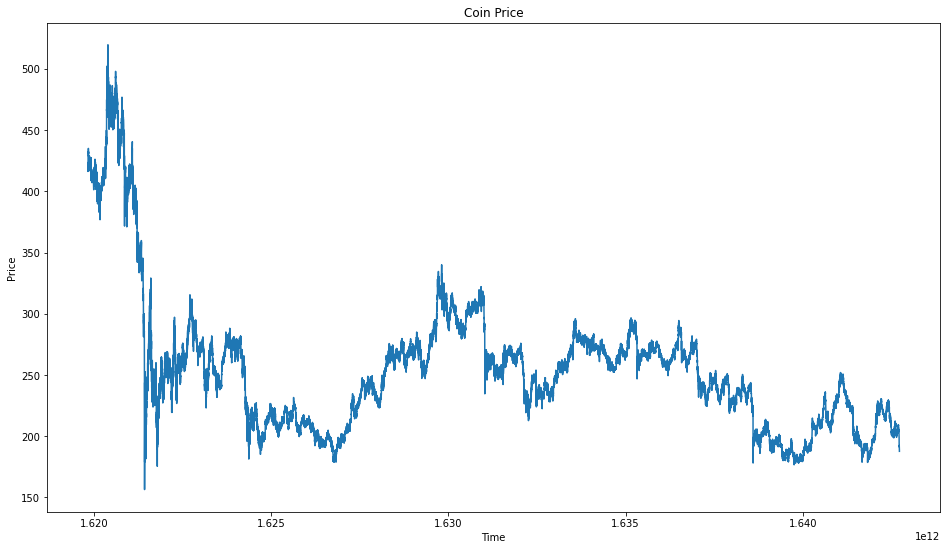

In [5]:
df = pd.DataFrame({"timestamp": timestamps, "qty": qtys, "price": prices}).set_index("timestamp")
df.price.iloc[::100].plot(title="Coin Price", xlabel="Time", ylabel="Price")

In [6]:
# choose a slice on which to test
wsize_days = 365
ts = int(data[-1][0] - 60 * 60 * 24 * 1000 * wsize_days)
idx = np.argmax(data[:, 0] >= ts)
dataslice = data[idx:]

In [7]:
hand_tuned = {
    "long": {
        "enabled": True,
        "ema_span_0": 1036.4758617491368,
        "ema_span_1": 1125.5167077975314,
        "initial_qty_pct": 0.01,
        "initial_eprice_ema_dist": -0.02,
        "wallet_exposure_limit": 1.0,
        "ddown_factor": 0.6,
        "rentry_pprice_dist": 0.015,
        "rentry_pprice_dist_wallet_exposure_weighting": 15,
        "min_markup": 0.02,
        "markup_range": 0.02,
        "n_close_orders": 7,
        "auto_unstuck_wallet_exposure_threshold": 0.15,
        "auto_unstuck_ema_dist": 0.02,
    },
    "short": {
        "enabled": True,
        "ema_span_0": 1036.4758617491368,
        "ema_span_1": 1125.5167077975314,
        "initial_qty_pct": 0.01,
        "initial_eprice_ema_dist": -0.02,
        "wallet_exposure_limit": 1.0,
        "ddown_factor": 0.6,
        "rentry_pprice_dist": 0.015,
        "rentry_pprice_dist_wallet_exposure_weighting": 36,
        "min_markup": 0.02,
        "markup_range": 0.02,
        "n_close_orders": 7,
        "auto_unstuck_wallet_exposure_threshold": 0.15,
        "auto_unstuck_ema_dist": 0.02,
    },
}
config_to_test = {**config, **hand_tuned}


Grid Span Long = 26.13%
Grid Span Short = 57.80%


,qty,price,type,psize,pprice,wallet_exposure,eprice_pprice_diff,ddown_factor,bkr_price
9,-13.709,296.83,short_rentry,-36.557,254.3135320185,0.929693979,0.1432350773,0.6000087535,527.8589542359
8,-8.568,252.95,short_rentry,-22.848,228.8032790616,0.522769732,0.0954604504,0.6000000000,666.4783490896
7,-5.355,228.97,short_rentry,-14.280,214.3152464986,0.306042172,0.0640029414,0.6000000000,914.5953585434
6,-3.347,214.92,short_rentry,-8.925,205.5223943978,0.183428737,0.0437260637,0.6000358551,1325.9705736695
5,-2.092,206.25,short_rentry,-5.578,199.8834940839,0.111495013,0.0308679075,0.6001147447,1992.6407547508
4,-1.307,200.63,short_rentry,-3.486,196.0628600115,0.068347513,0.0227639934,0.5998164296,3064.6801864601
3,-0.817,196.80,short_rentry,-2.179,193.3234144103,0.042125172,0.0176655772,0.5998531571,4782.5845433685
2,-0.511,194.05,short_rentry,-1.362,191.2379735683,0.026046612,0.0144912467,0.6004700353,7533.3818795888
1,-0.319,191.95,short_rentry,-0.851,189.5494359577,0.016130657,0.0125061945,0.5996240602,11940.4307520564
0,-0.532,188.11,short_ientry_normal,-0.532,188.1100000000,0.010007452,0.0000000000,NaN,18985.1024812030


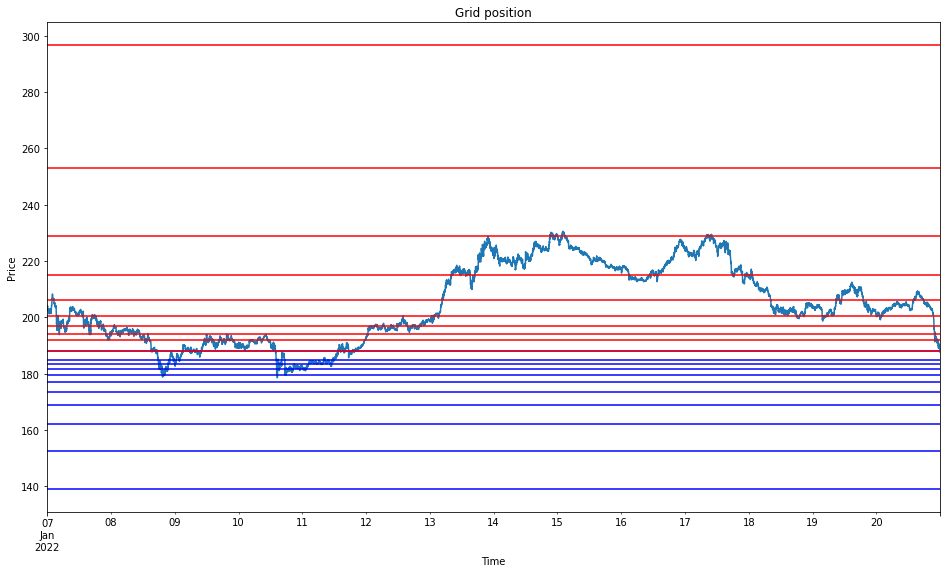

In [28]:
grid_long = calc_long_entries(
    Args().starting_balance,
    0.0,
    0.0,
    df.price.iloc[-1],
    df.price.iloc[-1],
    config_to_test['inverse'],
    config_to_test['qty_step'],
    config_to_test['price_step'],
    config_to_test['min_qty'],
    config_to_test['min_cost'],
    config_to_test['c_mult'],
    config_to_test['long']['initial_qty_pct'],
    config_to_test['long']['initial_eprice_ema_dist'],
    config_to_test['long']['ddown_factor'],
    config_to_test['long']['rentry_pprice_dist'],
    config_to_test['long']['rentry_pprice_dist_wallet_exposure_weighting'],
    config_to_test['long']['wallet_exposure_limit'],
    config_to_test['long']['auto_unstuck_ema_dist'],
    config_to_test['long']['auto_unstuck_wallet_exposure_threshold'],
)

grid_short = calc_short_entries(
    Args().starting_balance,
    0.0,
    0.0,
    df.price.iloc[-1],
    df.price.iloc[-1],
    config_to_test['inverse'],
    config_to_test['qty_step'],
    config_to_test['price_step'],
    config_to_test['min_qty'],
    config_to_test['min_cost'],
    config_to_test['c_mult'],
    config_to_test['short']['initial_qty_pct'],
    config_to_test['short']['initial_eprice_ema_dist'],
    config_to_test['short']['ddown_factor'],
    config_to_test['short']['rentry_pprice_dist'],
    config_to_test['short']['rentry_pprice_dist_wallet_exposure_weighting'],
    config_to_test['short']['wallet_exposure_limit'],
    config_to_test['short']['auto_unstuck_ema_dist'],
    config_to_test['short']['auto_unstuck_wallet_exposure_threshold'],
)

gdf_long = pd.DataFrame(grid_long, columns=["qty", "price", "type", "psize", "pprice", "wallet_exposure"])
gdf_long.loc[:, "eprice_pprice_diff"] = abs(gdf_long.price - gdf_long.pprice) / gdf_long.price
gdf_long.loc[:, "ddown_factor"] = gdf_long.qty / gdf_long.psize.shift()
gdf_long.loc[:, "bkr_price"] = gdf_long.apply(
    lambda x: calc_bankruptcy_price(Args().starting_balance, x.psize, x.pprice, 0.0, 0.0, config_to_test['inverse'], config_to_test['c_mult']),
    axis=1,
)
gdf_short = pd.DataFrame(grid_short, columns=["qty", "price", "type", "psize", "pprice", "wallet_exposure"])
gdf_short.loc[:, "eprice_pprice_diff"] = abs(gdf_short.price - gdf_short.pprice) / gdf_short.price
gdf_short.loc[:, "ddown_factor"] = gdf_short.qty / gdf_short.psize.shift()
gdf_short.loc[:, "bkr_price"] = gdf_short.apply(
    lambda x: calc_bankruptcy_price(Args().starting_balance, x.psize, x.pprice, 0.0, 0.0, config_to_test['inverse'], config_to_test['c_mult']),
    axis=1,
)

# Display grid on graph
n_ticks = 60 * 60 * 24 * 14  # 14 days
dfx = pd.DataFrame(
    {"timestamp": pd.to_datetime(timestamps[-n_ticks:], unit="ms"), "qty": qtys[-n_ticks:], "price": prices[-n_ticks:]}
).set_index("timestamp")
lastdayfrom = pd.to_datetime(Args().end_date)
# lastdayfrom = pd.Timestamp('2021-05-21')
fig = (
    dfx.price.loc[lastdayfrom - pd.Timedelta(days=280) : lastdayfrom]
    .iloc[::100]
    .plot(title="Grid position", xlabel="Time", ylabel="Price")
)
if config_to_test['long']['enabled']:
    for i, e in enumerate(gdf_long.itertuples()):
        fig.axhline(y=e.price, color="b", linestyle="-")
if config_to_test['short']['enabled']:
    for i, e in enumerate(gdf_short.itertuples()):
        fig.axhline(y=e.price, color="r", linestyle="-")
print(f"\nGrid Span Long = {-(gdf_long.price.iloc[-1] / gdf_long.price.iloc[0] - 1) * 100:.2f}%")
print(f"Grid Span Short = {(gdf_short.price.iloc[-1] / gdf_short.price.iloc[0] - 1) * 100:.2f}%")

pd.concat([gdf_long, gdf_short]).sort_values('price', ascending=False)


In [10]:
sts = time()
fills_long, fills_short, stats = backtest(config_to_test, dataslice)
elapsed = time() - sts
print(f"seconds elapsed {elapsed:.4f}")
longs, shorts, sdf, analysis = analyze_fills(fills_long, fills_short, stats, config_to_test)
pprint.pprint(analysis)

{'inverse': False, 'do_long': True, 'do_short': True, 'qty_step': 0.001, 'price_step': 0.01, 'min_qty': 0.001, 'min_cost': 5.0, 'c_mult': 1.0, 'ema_span_0': (1036.4758617491368, 1036.4758617491368), 'ema_span_1': (1125.5167077975314, 1125.5167077975314), 'initial_qty_pct': (0.01, 0.01), 'initial_eprice_ema_dist': (-0.02, -0.02), 'wallet_exposure_limit': (1.0, 1.0), 'ddown_factor': (0.6, 0.6), 'rentry_pprice_dist': (0.015, 0.015), 'rentry_pprice_dist_wallet_exposure_weighting': (15, 36), 'min_markup': (0.02, 0.02), 'markup_range': (0.02, 0.02), 'n_close_orders': (7, 7), 'auto_unstuck_wallet_exposure_threshold': (0.15, 0.15), 'auto_unstuck_ema_dist': (0.02, 0.02)}
seconds elapsed 33.4421
{'DGstd_long': 0.034037997755004226,
 'DGstd_short': 0.023488598984049237,
 'adg_DGstd_ratio_long': 0.06326666645870282,
 'adg_DGstd_ratio_short': 0.042647110474010305,
 'adg_long': 0.002153470650887928,
 'adg_per_exposure_long': 0.002153470650887928,
 'adg_per_exposure_short': 0.001001720875752474,
 'ad

In [11]:
sdf

,timestamp,bkr_price_long,bkr_price_short,psize_long,pprice_long,psize_short,pprice_short,price,closest_bkr_long,closest_bkr_short,balance_long,balance_short,equity_long,equity_short,wallet_exposure_long,wallet_exposure_short
0,1619827201000.0,0.0,0.0,0.000,0.0000000000,0.0,0.0000000000,421.74,1.0,1.0000000000,10000.0000000000,10000.00000000,10000.000000000,10000.00000000,0.0000000000,0.0
1,1619827261000.0,0.0,0.0,0.000,0.0000000000,0.0,0.0000000000,421.38,1.0,1.0000000000,10000.0000000000,10000.00000000,10000.000000000,10000.00000000,0.0000000000,0.0
2,1619827321000.0,0.0,0.0,0.000,0.0000000000,0.0,0.0000000000,421.75,1.0,1.0000000000,10000.0000000000,10000.00000000,10000.000000000,10000.00000000,0.0000000000,0.0
3,1619827381000.0,0.0,0.0,0.000,0.0000000000,0.0,0.0000000000,421.86,1.0,1.0000000000,10000.0000000000,10000.00000000,10000.000000000,10000.00000000,0.0000000000,0.0
4,1619827441000.0,0.0,0.0,0.000,0.0000000000,0.0,0.0000000000,422.00,1.0,1.0000000000,10000.0000000000,10000.00000000,10000.000000000,10000.00000000,0.0000000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
381595,1642722901000.0,0.0,0.0,39.091,199.4575168437,0.0,206.1507462346,188.04,1.0,0.6365840124,15591.5636689589,12189.04615215,15145.241518022,12189.04615215,0.5000777316,0.0
381596,1642722961000.0,0.0,0.0,39.091,199.4575168437,0.0,206.1507462346,187.84,1.0,0.6365840124,15591.5636689589,12189.04615215,15137.423318022,12189.04615215,0.5000777316,0.0
381597,1642723021000.0,0.0,0.0,39.091,199.4575168437,0.0,206.1507462346,187.86,1.0,0.6365840124,15591.5636689589,12189.04615215,15138.205138022,12189.04615215,0.5000777316,0.0
381598,1642723081000.0,0.0,0.0,39.091,199.4575168437,0.0,206.1507462346,187.80,1.0,0.6365840124,15591.5636689589,12189.04615215,15135.859678022,12189.04615215,0.5000777316,0.0


<AxesSubplot:title={'center':'Balance and equity long'}, xlabel='Time', ylabel='Balance'>

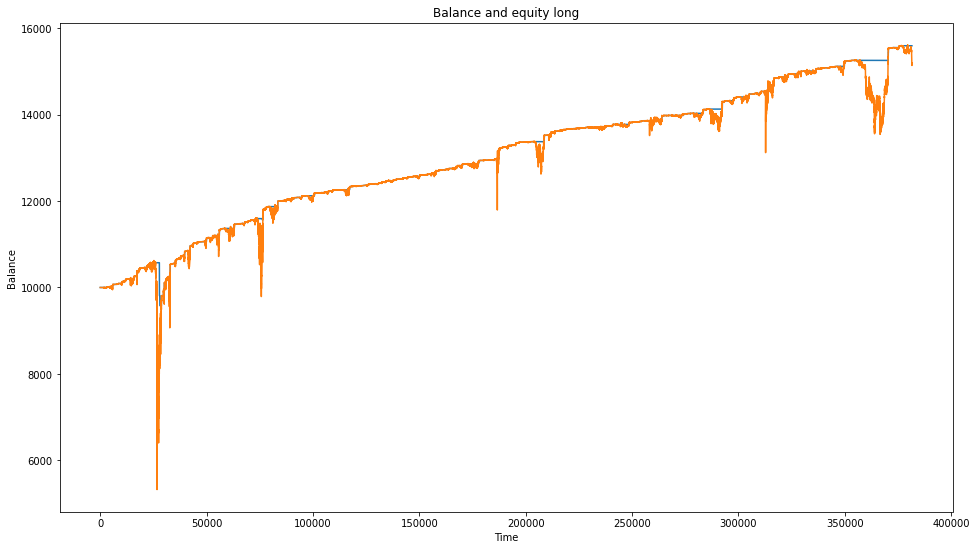

In [12]:
sdf.balance_long.plot()
sdf.equity_long.plot(title="Balance and equity long", xlabel="Time", ylabel="Balance")

<AxesSubplot:title={'center':'Balance and equity short'}, xlabel='Time', ylabel='Balance'>

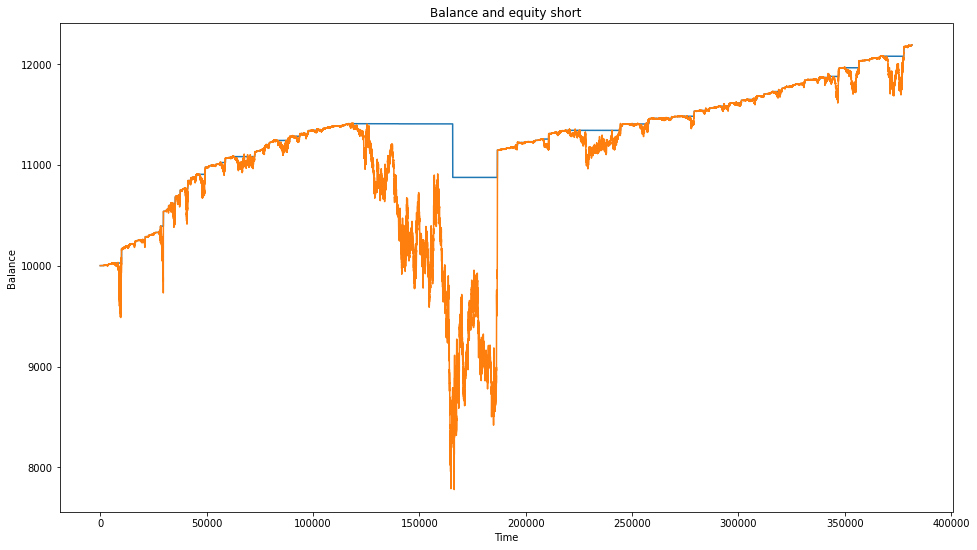

In [13]:
sdf.balance_short.plot()
sdf.equity_short.plot(title="Balance and equity short", xlabel="Time", ylabel="Balance")

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.9/site-packages/matplotlib/pyplot.py'>

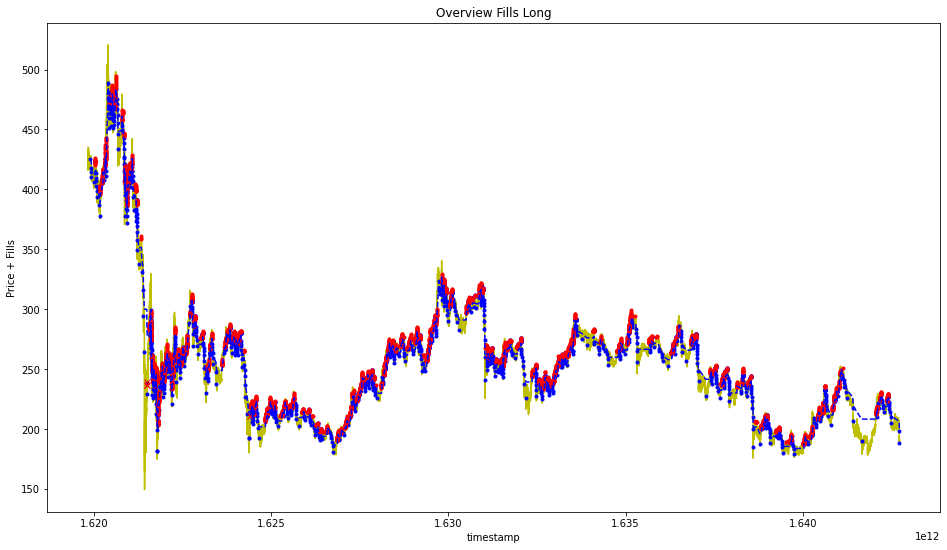

In [14]:
plot_fills(df, longs, plot_whole_df=True, title="Overview Fills Long")

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.9/site-packages/matplotlib/pyplot.py'>

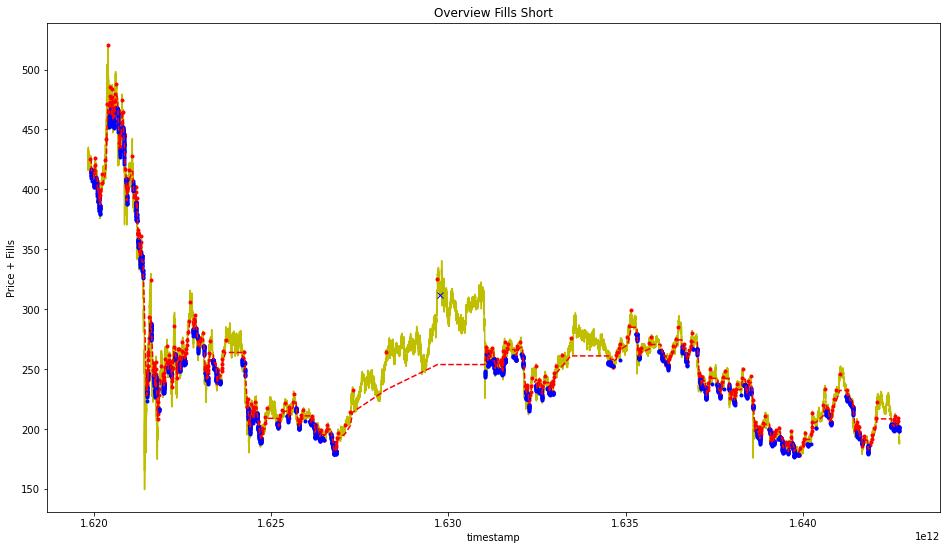

In [15]:
plot_fills(df, shorts, plot_whole_df=True, title="Overview Fills Short")

<AxesSubplot:title={'center':'Position size in terms of contracts'}, xlabel='Time', ylabel='Short Position size'>

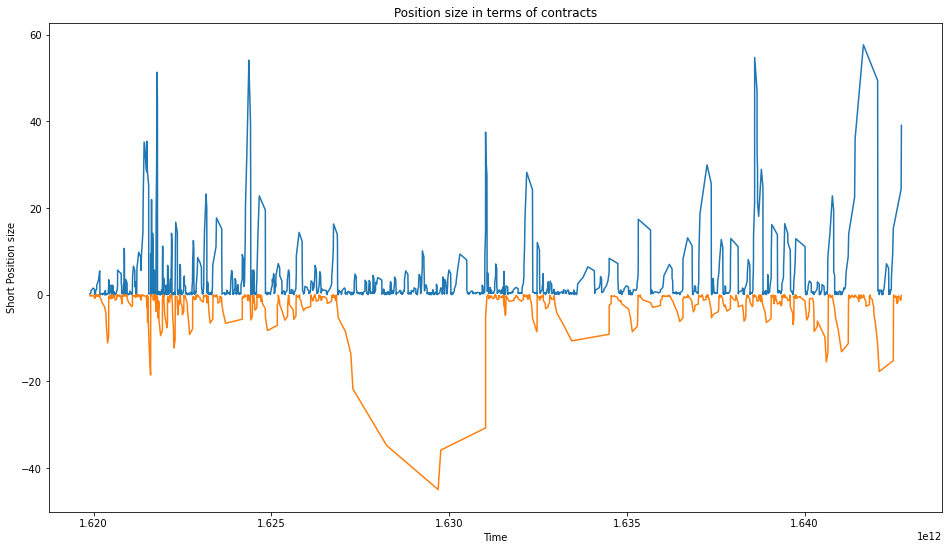

In [16]:
longs[longs.psize > 0.0].psize.plot(
    title="Position size in terms of contracts",
    xlabel="Time",
    ylabel="Long Position size",
)
shorts[shorts.psize < 0.0].psize.plot(
    title="Position size in terms of contracts",
    xlabel="Time",
    ylabel="Short Position size",
)

In [17]:
shorts

,trade_id,timestamp,pnl,fee_paid,balance,equity,qty,price,psize,pprice,type,wallet_exposure
timestamp,,,,,,,,,,,,
1619894916000.0,67715,1619894916000.0,0.0000000000,-0.019980170,9999.9800198300,9999.970619830,-0.235,425.11,-0.235,425.1100000000,short_ientry_normal,0.0099901050
1619926303000.0,99102,1619926303000.0,0.2808300000,-0.002749560,10000.2581002700,10001.983180270,0.033,416.60,-0.202,425.1100000000,short_nclose,0.0085870004
1619926617000.0,99416,1619926617000.0,0.3273600000,-0.002740254,10000.5827200160,10002.282860016,0.033,415.19,-0.169,425.1100000000,short_nclose,0.0071839404
1619926623000.0,99422,1619926623000.0,0.3742200000,-0.002730882,10000.9542091340,10002.594369134,0.033,413.77,-0.136,425.1100000000,short_nclose,0.0057809444
1619926679000.0,99478,1619926679000.0,0.0000000000,-0.001078766,10000.9531303680,10002.334370368,-0.013,414.91,-0.149,424.2200671141,short_ientry_partial,0.0063202766
...,...,...,...,...,...,...,...,...,...,...,...,...
1642714154000.0,22886953,1642714154000.0,0.8416141739,-0.006139890,12184.6226806454,12188.017300326,0.153,200.65,-0.616,206.1507462346,short_nclose,0.0104220593
1642714507000.0,22887306,1642714507000.0,0.9533749201,-0.006158768,12185.5698967976,12188.462361558,0.154,199.96,-0.462,206.1507462346,short_nclose,0.0078159368
1642714637000.0,22887436,1642714637000.0,1.0596349201,-0.006137516,12186.6233942017,12188.745744042,0.154,199.27,-0.308,206.1507462346,short_nclose,0.0052101741


<AxesSubplot:title={'center':'Average entry price'}, xlabel='Time', ylabel='Price'>

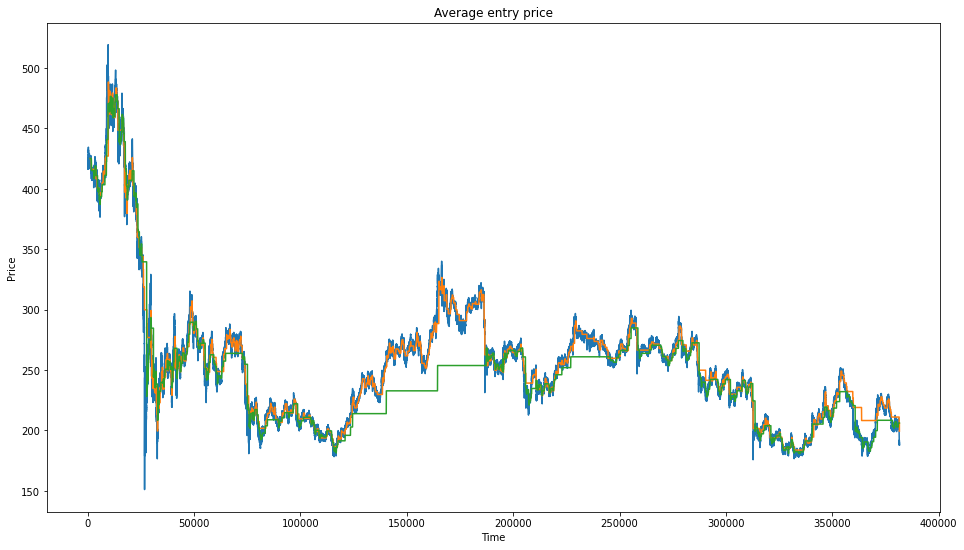

In [18]:
sdf.price.plot(title="Average entry price", xlabel="Time", ylabel="Price")
sdf.pprice_long.replace(0.0, np.nan).plot()
sdf.pprice_short.replace(0.0, np.nan).plot()

Price action distance long mean 0.017266 std 0.029470


<AxesSubplot:title={'center':'Price action distance'}, xlabel='Time', ylabel='Price action distance'>

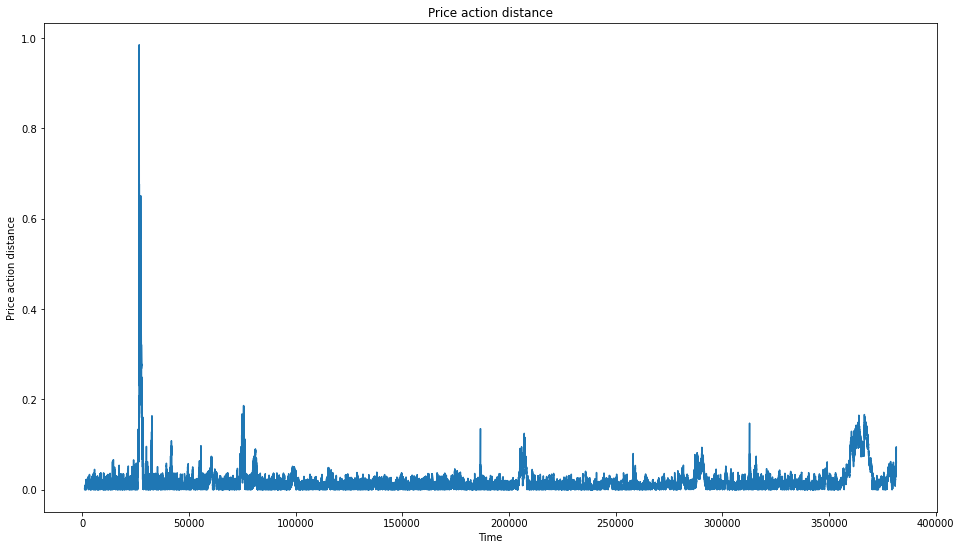

In [19]:
lpprices = sdf[sdf.psize_long != 0.0]
PADistance_long = (lpprices.pprice_long - lpprices.price).abs() / lpprices.price
print(f"Price action distance long mean {PADistance_long.mean():.6f} std {PADistance_long.std():.6f}")
PADistance_long.plot(title="Price action distance", xlabel="Time", ylabel="Price action distance")

Mean price action distance short 0.040670


<AxesSubplot:title={'center':'Price action distance'}, xlabel='Time', ylabel='Price action distance'>

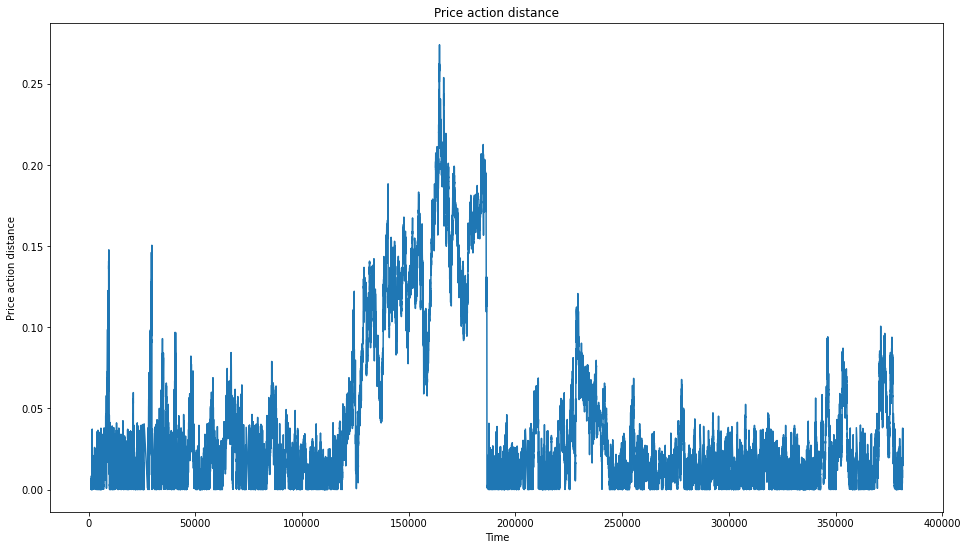

In [20]:
spprices = sdf[sdf.psize_short != 0.0]
PADistance_short = (spprices.pprice_short - spprices.price).abs() / spprices.price
print(f"Mean price action distance short {PADistance_short.mean():.6f}")
PADistance_short.plot(title="Price action distance", xlabel="Time", ylabel="Price action distance")

spans in minutes [1036.4758617491368, 1080.079117299977, 1125.5167077975314] n_days 265.0


<AxesSubplot:title={'center':'Unstucking Bands and Initial Entry Band'}, xlabel='timestamp'>

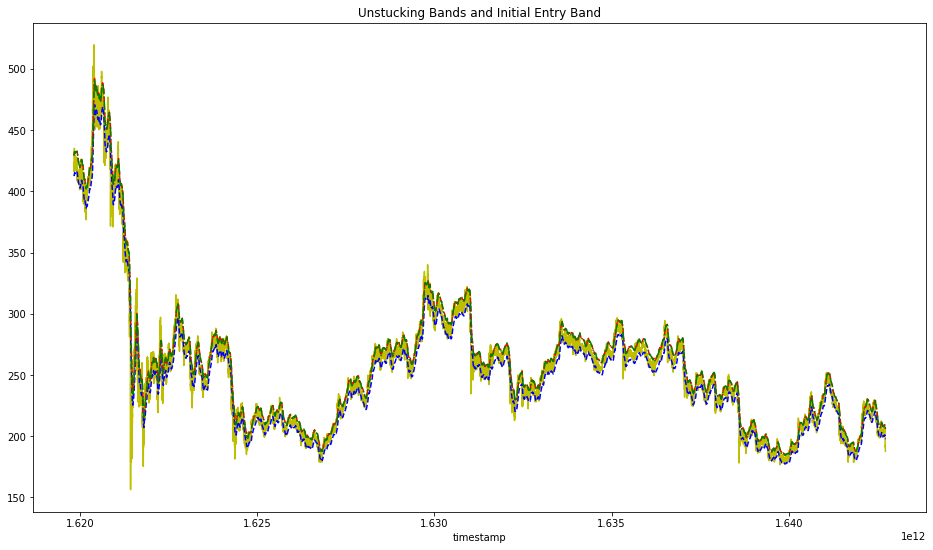

In [21]:
# Inspect long EMAs
# blue: lower unstucking; red: upper unstucking; green: initial entry
spans = [
    config_to_test["long"]["ema_span_0"],
    (config_to_test["long"]["ema_span_0"] * config_to_test["long"]["ema_span_1"]) ** 0.5,
    config_to_test["long"]["ema_span_1"],
]
print(
    f"spans in minutes {spans}",
    f"n_days {(df.index[-1] - df.index[0]) / 1000 / 60 / 60 / 24:.1f}",
)
for i in range(3):
    # change to seconds
    spans[i] *= 60
emas = pd.DataFrame({str(span): df.price.ewm(span=span, adjust=False).mean() for span in spans})
ema_band_lower = emas.min(axis=1)
unstucking_band_lower = ema_band_lower * (1 - config_to_test["long"]["auto_unstuck_ema_dist"])
ema_band_upper = emas.max(axis=1)
unstucking_band_upper = ema_band_upper * (1 + config_to_test["long"]["auto_unstuck_ema_dist"])
long_ientry_band = ema_band_lower * (1 - config_to_test["long"]["initial_eprice_ema_dist"])
df.iloc[::100].price.plot(style="y-", title="Unstucking Bands and Initial Entry Band")
unstucking_band_lower.iloc[::100].plot(
    style="b--",
)
unstucking_band_upper.iloc[::100].plot(style="r--")
long_ientry_band.iloc[::100].plot(style="g-.")

spans in minutes [1036.4758617491368, 1080.079117299977, 1125.5167077975314] n_days 265.0


<AxesSubplot:title={'center':'Unstucking Bands and Initial Entry Band'}, xlabel='timestamp'>

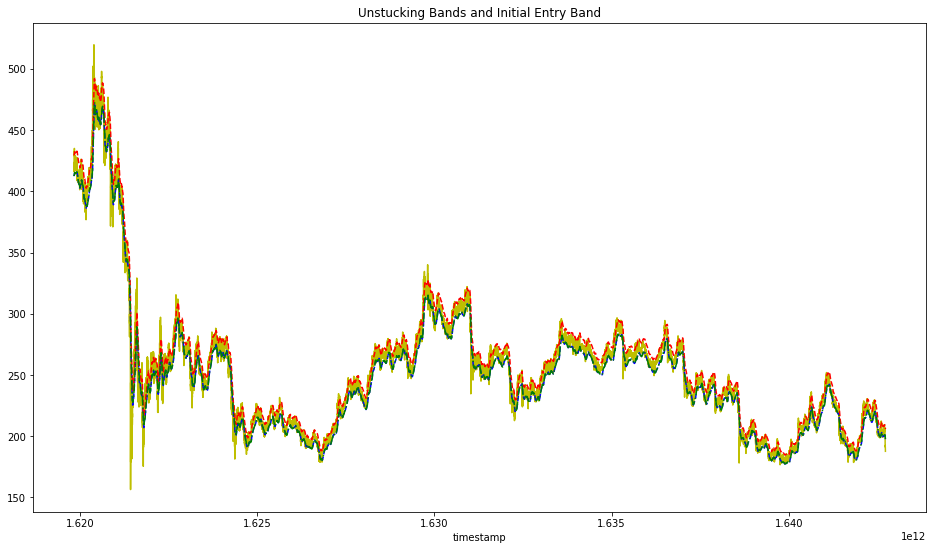

In [22]:
# Inspect short EMAs
# blue: lower unstucking; red: upper unstucking; green: initial entry
spans = [
    config_to_test["short"]["ema_span_0"],
    (config_to_test["short"]["ema_span_0"] * config_to_test["short"]["ema_span_1"]) ** 0.5,
    config_to_test["short"]["ema_span_1"],
]
print(
    f"spans in minutes {spans}",
    f"n_days {(df.index[-1] - df.index[0]) / 1000 / 60 / 60 / 24:.1f}",
)
for i in range(3):
    # change to seconds
    spans[i] *= 60
emas = pd.DataFrame({str(span): df.price.ewm(span=span, adjust=False).mean() for span in spans})
ema_band_lower = emas.min(axis=1)
unstucking_band_lower = ema_band_lower * (1 - config_to_test["short"]["auto_unstuck_ema_dist"])
ema_band_upper = emas.max(axis=1)
unstucking_band_upper = ema_band_upper * (1 + config_to_test["short"]["auto_unstuck_ema_dist"])
short_ientry_band = ema_band_upper * (1 + config_to_test["short"]["initial_eprice_ema_dist"])
df.iloc[::100].price.plot(style="y-", title="Unstucking Bands and Initial Entry Band")
unstucking_band_lower.iloc[::100].plot(style="b--")
unstucking_band_upper.iloc[::100].plot(style="r--")
short_ientry_band.iloc[::100].plot(style="g-.")